Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
import pandas as pd
# import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# And the sale price was more than 100 thousand and less than 2 million.
print('shape with all sales prices =',df.shape)
df = df[(df['SALE_PRICE']>=100000) & (df['SALE_PRICE']<=2000000)]
print('shape with prices between 100k and 2M =',df.shape)

# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

# Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
print('shape for just single family dwellings =',df.shape)

# Cast SALE_DATE into a datetime datatype
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Reduce cardinality for NEIGHBORHOOD feature
# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index
# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

# This only appears one time and winds up in the
# testing data and not in the training data
df = df[df['RESIDENTIAL_UNITS'] != 2]

# To avoid a NaN error on the one hot encoding step
# This column is all Nan, except one value.
df.drop(labels='APARTMENT_NUMBER', axis=1, inplace=True)

# Drop columns with 1 unique value
drop_list = []
for column in df.columns:
  cardinality = len(df[column].unique())
  if(cardinality == 1):
    drop_list.append(column)

print('Dropping columns',drop_list)
df.drop(labels=drop_list, axis=1, inplace=True)


shape with all sales prices = (23040, 21)
shape with prices between 100k and 2M = (13471, 21)
shape for just single family dwellings = (3164, 21)
Dropping columns ['BUILDING_CLASS_CATEGORY', 'EASE-MENT', 'TAX_CLASS_AT_TIME_OF_SALE']


In [ ]:
# Print the number of unique values in each column
print('Column = Unique Values')
for column in df.columns:
  cardinality = len(df[column].unique())
  print(column,'=',cardinality)

Column = Unique Values
BOROUGH = 5
NEIGHBORHOOD = 11
TAX_CLASS_AT_PRESENT = 2
BLOCK = 2503
LOT = 332
BUILDING_CLASS_AT_PRESENT = 13
ADDRESS = 3147
ZIP_CODE = 126
RESIDENTIAL_UNITS = 2
COMMERCIAL_UNITS = 3
TOTAL_UNITS = 4
LAND_SQUARE_FEET = 1037
GROSS_SQUARE_FEET = 1050
YEAR_BUILT = 89
BUILDING_CLASS_AT_TIME_OF_SALE = 11
SALE_PRICE = 1002
SALE_DATE = 91


In [ ]:
# A generic function which will one hot encode columns which have a cardinality at or below max_c
# returns a new DataFrame
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode(data, max_c):
  one_hot_columns = []
  for column in data.columns:
    cardinality = len(data[column].unique())
    if(cardinality <= max_c):
      one_hot_columns.append(column)

  enc = OneHotEncoder(sparse=False)
  onehot = enc.fit_transform(data[one_hot_columns])
  onehot = pd.DataFrame(onehot, columns=enc.get_feature_names(one_hot_columns))

  data = data.drop(one_hot_columns, axis=1)
  data = data.reset_index().drop(labels='index', axis=1)
  return pd.concat([data, onehot], axis=1)
  
# One hot encode columns which have a cardinality at or below 13
df = one_hot_encode(df, 13)

In [ ]:
df

,BLOCK,LOT,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_ST. ALBANS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_S1,RESIDENTIAL_UNITS_0.0,RESIDENTIAL_UNITS_1.0,RESIDENTIAL_UNITS_2.0,COMMERCIAL_UNITS_0.0,COMMERCIAL_UNITS_1.0,COMMERCIAL_UNITS_2.0,TOTAL_UNITS_0.0,TOTAL_UNITS_1.0,TOTAL_UNITS_2.0,TOTAL_UNITS_3.0,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BUILDING_CLASS_AT_TIME_OF_SALE_S1
0,5495,801,4832 BAY PARKWAY,11230.0,"6,800",1325.0,1930.0,550000,2019-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7918,72,80-23 232ND STREET,11427.0,"4,000",2001.0,1940.0,200000,2019-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4210,19,1260 RHINELANDER AVE,10461.0,"3,500",2043.0,1925.0,810000,2019-01-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5212,69,469 E 25TH ST,11226.0,"4,000",2680.0,1899.0,125000,2019-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7930,121,5521 WHITTY LANE,11203.0,"1,710",1872.0,1940.0,620000,2019-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,13215,3,244-15 135 AVENUE,11422.0,"3,300",1478.0,1925.0,635000,2019-04-30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3160,11612,73,10919 132ND STREET,11420.0,"2,400",1280.0,1930.0,514000,2019-04-30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3161,11808,50,135-24 122ND STREET,11420.0,"4,000",1333.0,1945.0,635000,2019-04-30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3162,12295,23,134-34 157TH STREET

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   BLOCK                                  3164 non-null   int64         
 1   LOT                                    3164 non-null   int64         
 2   ADDRESS                                3164 non-null   object        
 3   ZIP_CODE                               3164 non-null   float64       
 4   LAND_SQUARE_FEET                       3164 non-null   object        
 5   GROSS_SQUARE_FEET                      3164 non-null   float64       
 6   YEAR_BUILT                             3164 non-null   float64       
 7   SALE_PRICE                             3164 non-null   int64         
 8   SALE_DATE                              3164 non-null   datetime64[ns]
 9   BOROUGH_1                              3164 non-null   float64 

In [ ]:
# Split between features and target, as X and y
import numpy as np

target = 'SALE_PRICE'
y = df[target]
# y = np.expand_dims(y, axis=1)

X = df.select_dtypes(exclude=['object','datetime64[ns]'])
X = X.drop(columns=[target])

print('shape of X and y =', X.shape, y.shape)

# Split between train and test
# Use data from January — March 2019 to train. Use data from April 2019 to test.
train_mask = df['SALE_DATE'] < pd.to_datetime('2019-04-01')

X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print('shape of X_train and X_test =', X_train.shape, X_test.shape)
print('shape of y_train and y_test =', y_train.shape, y_test.shape)

shape of X and y = (3163, 56) (3163,)
shape of X_train and X_test = (2517, 56) (646, 56)
shape of y_train and y_test = (2517,) (646,)


In [ ]:
# A function which prints all the error metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

def print_error_metrics(y_ground, y_pred):
  # MAE
  mae = mean_absolute_error(y_ground, y_pred)
  print('MAE = $'+format(mae, ',.2f'))

  # RMSD
  rmsd = np.sqrt(mean_squared_error(y_ground, y_pred))
  print('RMSD = $'+format(rmsd, ',.2f'))

  # R^2
  r2 = r2_score(y_ground, y_pred)
  print('Training R^2:', format(r2,'.3f'),'out of 1.000')

def get_mae(y_ground, y_pred):
  mae = mean_absolute_error(y_ground, y_pred)
  return '$'+format(mae, ',.2f')


In [ ]:
# Make and test a baseline model based on the median price

train_med = y_train.median()
print('Median rent = $'+format(train_med,',.2f'))

# Calculate the training error
# y_train = train['price']
y_predict = np.full(y_train.shape, train_med)
print('\nError for the training set:')
print_error_metrics(y_train, y_predict)

# Calculate the testing error
# y_test = test['price']
y_predict = np.full(y_test.shape, train_med)
print('\nError for the testing set:')
print_error_metrics(y_test, y_predict)

Median rent = $560,000.00

Error for the training set:
MAE = $209,743.92
RMSD = $301,263.40
Training R^2: -0.043 out of 1.000

Error for the testing set:
MAE = $215,077.81
RMSD = $316,714.34
Training R^2: -0.100 out of 1.000


In [ ]:
# Print the number of unique values in each column
def cardinalities(data):
  print('Column = Unique Values')
  for column in data.columns:
    cardinality = len(data[column].unique())
    print(column,'=',cardinality)

In [ ]:
# Do feature selection with SelectKBest.
from sklearn.feature_selection import SelectKBest, f_regression

k = 5
selector = SelectKBest(score_func = f_regression, k = k)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print(X_train.shape, X_train_selected.shape, X_test_selected.shape)

(2517, 56) (2517, 5) (646, 5)


In [ ]:
# Which features were selected?
selected_mask = selector.get_support()
cols = X_train.columns
print(cols[selected_mask])

Index(['ZIP_CODE', 'GROSS_SQUARE_FEET', 'BOROUGH_3',
       'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3'],
      dtype='object')


In [ ]:
# Make some linear models with some k best features
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

for k in range(1,len(X_train.columns)):
  # Get SelectKBest Features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  # Make a linear model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_predict = model.predict(X_test_selected)

  # Get and print the MAE
  mae = get_mae(y_test, y_predict)
  print(mae+f' - Best {k} Linear Model')

$185,925.62 - Best 1 Linear Model
$184,834.47 - Best 2 Linear Model
$184,834.47 - Best 3 Linear Model
$185,851.12 - Best 4 Linear Model
$183,977.96 - Best 5 Linear Model
$184,449.61 - Best 6 Linear Model
$177,543.94 - Best 7 Linear Model
$166,922.94 - Best 8 Linear Model
$165,217.16 - Best 9 Linear Model
$164,116.20 - Best 10 Linear Model
$164,117.81 - Best 11 Linear Model
$162,534.60 - Best 12 Linear Model
$162,550.52 - Best 13 Linear Model
$164,895.87 - Best 14 Linear Model
$164,593.54 - Best 15 Linear Model
$164,593.54 - Best 16 Linear Model
$164,478.26 - Best 17 Linear Model
$164,478.26 - Best 18 Linear Model
$164,478.26 - Best 19 Linear Model
$164,478.26 - Best 20 Linear Model
$164,490.96 - Best 21 Linear Model
$164,490.96 - Best 22 Linear Model
$163,854.53 - Best 23 Linear Model
$163,285.72 - Best 24 Linear Model
$163,900.06 - Best 25 Linear Model
$163,900.06 - Best 26 Linear Model
$163,900.06 - Best 27 Linear Model
$163,900.06 - Best 28 Linear Model
$163,900.06 - Best 29 Linear 

Ridge Models
Best Score = $164,072.33, K = 10, Alpha = 0.001082636733874054


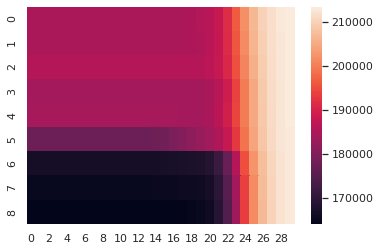

In [ ]:
# Fit a ridge regression model with multiple features.
# Use the normalize=True parameter (or do feature scaling beforehand — use
# the scaler's fit_transform method with the train set, and the scaler's
# transform method with the test set)
from sklearn.linear_model import Ridge

print('Ridge Models')
def ridge(k, alpha):
  # Get SelectKBest Features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  # Fit linear model
  ridge = Ridge(alpha=alpha, normalize=True)
  ridge.fit(X_train_selected, y_train)
  y_predict = ridge.predict(X_test_selected)
  
  return mean_absolute_error(y_test, y_predict)

best_score = 2000000
best_k = np.nan
best_alpha = np.nan
K = range(2,11)
Alpha = np.logspace(-7, 2, num=30)
scores = np.zeros((len(K),len(Alpha)))
for i, k in enumerate(K):
  for j, alpha in enumerate(Alpha):
    score = ridge(k=k, alpha=alpha)
    scores[i,j] = score
    if score < best_score:
      best_score = score
      best_k = k
      best_alpha = alpha

best_score = '$'+format(best_score, ',.2f')
print(f'Best Score = {best_score}, K = {best_k}, Alpha = {best_alpha}')
# print(f'Best K = {best_k}, Best Alpha = {best_alpha}')

import seaborn as sns

sns.heatmap(scores)
plt.show()

In [ ]:
# All Mean Absolute Errors
print('Predicting Property Sale Prices for Single Family Homes in New York City:')

min_price = '$'+format(df.SALE_PRICE.min(), ',d')
max_price = '$'+format(df.SALE_PRICE.max(), ',d')
print('Sale prices range from',min_price,'to',max_price)

print('\nMean Absolute Error - Model')

def baseline():
  # Baseline Model (median)
  y_predict = np.full(y_test.shape, y_train.median())
  mae = get_mae(y_test, y_predict)
  print(mae+' - Baseline model (median)')
baseline()

def best_1_linear():
  # Best 10 Linear Model
  from sklearn.feature_selection import SelectKBest, f_regression
  from sklearn.linear_model import LinearRegression

  # Get SelectKBest Features
  k=1
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  # Make a linear model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_predict = model.predict(X_test_selected)

  # Get and print the MAE
  mae = get_mae(y_test, y_predict)
  print(mae+f' - Best {k} Linear Model')
best_1_linear()

def best_10_linear():
  # Best 10 Linear Model
  from sklearn.feature_selection import SelectKBest, f_regression
  from sklearn.linear_model import LinearRegression

  # Get SelectKBest Features
  k=10
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  # Make a linear model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_predict = model.predict(X_test_selected)

  # Get and print the MAE
  mae = get_mae(y_test, y_predict)
  print(mae+f' - Best {k} Linear Model')
best_10_linear()

def best_1_ridge():
  # $185,925.62 - Best K=1 Ridge, Alpha = 1e-07
  best_score = ridge(k=1, alpha=1e-07)
  best_score = '$'+format(best_score, ',.2f')
  print(f'{best_score} - K=1 Ridge, Best Alpha = {1e-07}')
best_1_ridge()

def best_10_ridge():
  best_score = ridge(k=10, alpha=0.0010241058042981246)
  best_score = '$'+format(best_score, ',.2f')
  print(f'{best_score} - K=10 Ridge, Best Alpha = {0.0010241058042981246}')
best_10_ridge()

Predicting Property Sale Prices for Single Family Homes in New York City:
Sale prices range from $100,000 to $2,000,000

Mean Absolute Error - Model
$215,077.81 - Baseline model (median)
$185,925.62 - Best 1 Linear Model
$164,116.20 - Best 10 Linear Model
$185,925.62 - K=1 Ridge, Best Alpha = 1e-07
$164,072.01 - K=10 Ridge, Best Alpha = 0.0010241058042981246
